In [ ]:
!unzip data.zip

In [ ]:
# ## 1. Setup and Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import itertools
import random
import os
import datetime

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

from sklearn.metrics import confusion_matrix, classification_report

# TensorFlow 로그 간소화
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

In [ ]:
# ## 2. Data Loading & Verification
try:
    train_dir = './data/train'
    test_dir = './data/test'

    # 클래스 이름 확인을 위해 경로 존재 여부 체크
    if not os.path.exists(train_dir) or not os.path.exists(test_dir):
        raise FileNotFoundError
except FileNotFoundError:
    print("="*50)
    print("경고: './data/train' 또는 './data/test' 경로를 찾을 수 없습니다.")
    print("Colab 또는 다른 환경에서 실행하는 경우, 데이터셋 경로를 올바르게 수정해주세요.")
    print("="*50)
    # 스크립트가 중단되지 않도록 임시 경로를 사용합니다. 실제 사용 시에는 이 부분을 삭제하고 올바른 경로를 입력하세요.
    train_dir = 'path_to_your_train_data'
    test_dir = 'path_to_your_test_data'

In [12]:
# 이미지 관련 하이퍼파라미터 설정
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

# 데이터셋 생성 (경로가 존재할 경우에만 실행)
if os.path.exists(train_dir) and os.path.exists(test_dir):
    train_data = tf.keras.preprocessing.image_dataset_from_directory(
        directory=train_dir,
        image_size=IMG_SIZE,
        label_mode='categorical',
        batch_size=BATCH_SIZE
    )

    test_data = tf.keras.preprocessing.image_dataset_from_directory(
        directory=test_dir,
        image_size=IMG_SIZE,
        label_mode='categorical',
        batch_size=BATCH_SIZE,
        shuffle=False  # 평가 시에는 순서가 중요하므로 셔플하지 않음
    )

    # 클래스 이름 확인
    class_names = train_data.class_names
    print(f"Class names found: {class_names}")
else:
    print("데이터셋을 로드할 수 없어 EDA 및 모델 학습을 건너뜁니다.")
    # 스크립트의 나머지 부분이 실행되지 않도록 class_names를 None으로 설정
    class_names = None

Found 711 files belonging to 3 classes.
Found 114 files belonging to 3 classes.
Class names found: ['adidas', 'converse', 'nike']


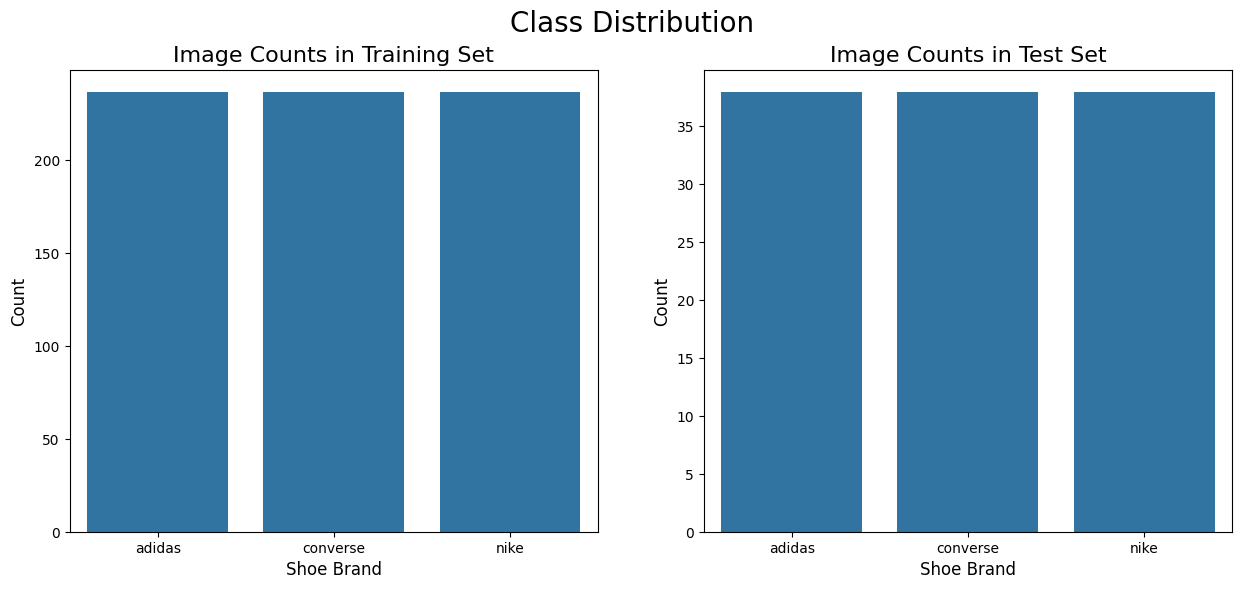

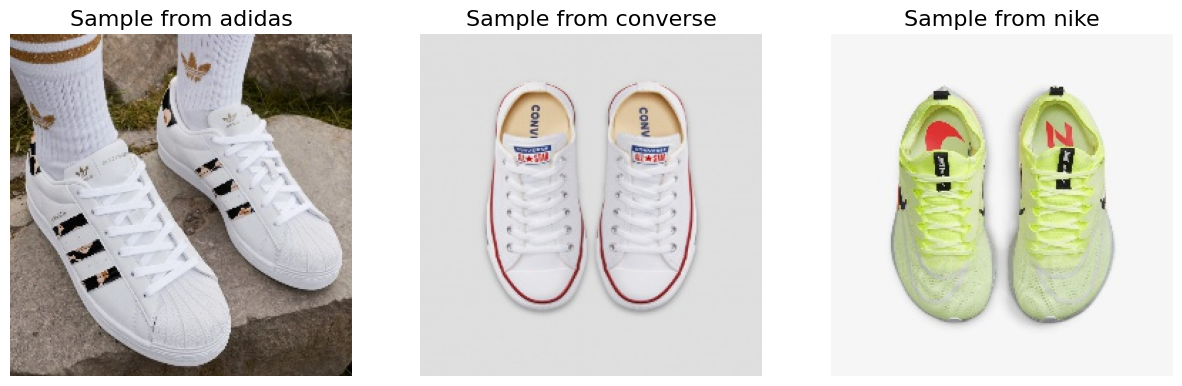

In [13]:
# ## 3. Exploratory Data Analysis (EDA)
if class_names:
    # 클래스별 데이터 수량 확인 및 시각화
    train_counts = {cls: len(os.listdir(os.path.join(train_dir, cls))) for cls in class_names}
    test_counts = {cls: len(os.listdir(os.path.join(test_dir, cls))) for cls in class_names}

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    sns.barplot(x=list(train_counts.keys()), y=list(train_counts.values()), ax=ax1)
    ax1.set_title('Image Counts in Training Set', fontsize=16)
    ax1.set_xlabel('Shoe Brand', fontsize=12)
    ax1.set_ylabel('Count', fontsize=12)

    sns.barplot(x=list(test_counts.keys()), y=list(test_counts.values()), ax=ax2)
    ax2.set_title('Image Counts in Test Set', fontsize=16)
    ax2.set_xlabel('Shoe Brand', fontsize=12)
    ax2.set_ylabel('Count', fontsize=12)

    plt.suptitle('Class Distribution', fontsize=20)
    plt.show()

    # 각 클래스별 샘플 이미지 확인
    plt.figure(figsize=(15, 10))
    for i, class_name in enumerate(class_names):
        class_path = os.path.join(train_dir, class_name)
        random_image = random.choice(os.listdir(class_path))
        img_path = os.path.join(class_path, random_image)
        img = mpimg.imread(img_path)

        plt.subplot(1, len(class_names), i + 1)
        plt.imshow(img)
        plt.title(f'Sample from {class_name}', fontsize=16)
        plt.axis('off')

    plt.show()

In [14]:
# ## 4. Model Building (Transfer Learning)
# Data Augmentation Layer
data_augmentation = Sequential([
    layers.RandomFlip('horizontal'),
    layers.RandomRotation(0.2),
    layers.RandomHeight(0.2),
    layers.RandomWidth(0.2),
    layers.RandomZoom(0.2),
], name='data_augmentation')

In [22]:
early_stopping = EarlyStopping(monitor='val_loss',
                                   patience=5,  # 5 epoch 동안 개선이 없으면 중단
                                   restore_best_weights=True)

# Create the base model (EfficientNetB0) with pre-trained weights
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

In [23]:
# Build the final model architecture
inputs = layers.Input(shape=(224, 224, 3), name='input_layer')
x = data_augmentation(inputs)
x = base_model(x, training=False)  # Pass augmented data to the base model in inference mode
x = layers.GlobalAveragePooling2D(name='global_average_pooling')(x)
outputs = layers.Dense(len(class_names), activation='softmax', name='output_layer')(x)
model = tf.keras.Model(inputs, outputs)

In [24]:
# Compile the model
model.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(),
    metrics=['accuracy']
)

# 모델 구조 요약
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ data_augmentation (Sequential)  │ (None, None, None, 3)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, None, None,     │     4,049,571 │
│                                 │ 1280)                  │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling          │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 3)              │         3,843 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,053,414 (15.46 MB)

 Trainable params: 3,843 (15.01 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

In [26]:
# ## 5. Model Training
if class_names:
    EPOCHS = 20  # EarlyStopping을 사용하므로 최대 Epoch를 20으로 설정

    history = model.fit(
        train_data,
        epochs=EPOCHS,
        validation_data=test_data,
        callbacks=[ early_stopping]
    )

Epoch 1/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 24s 404ms/step - accuracy: 0.4640 - loss: 1.0523 - val_accuracy: 0.5351 - val_loss: 0.9434
Epoch 2/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 11s 118ms/step - accuracy: 0.6760 - loss: 0.8025 - val_accuracy: 0.6404 - val_loss: 0.8037
Epoch 3/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 3s 123ms/step - accuracy: 0.7555 - loss: 0.6871 - val_accuracy: 0.7456 - val_loss: 0.7120
Epoch 4/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 7s 203ms/step - accuracy: 0.7562 - loss: 0.6222 - val_accuracy: 0.7632 - val_loss: 0.6626
Epoch 5/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 3s 141ms/step - accuracy: 0.8075 - loss: 0.5595 - val_accuracy: 0.7895 - val_loss: 0.6308
Epoch 6/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 5s 117ms/step - accuracy: 0.7911 - loss: 0.5572 - val_accuracy: 0.8070 - val_loss: 0.6009
Epoch 7/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 3s 141ms/step - accuracy: 0.8300 - loss: 0.4878 - val_accuracy: 0.8158 - val_loss: 0.5755
Epoch 8/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 3s 121ms/step - accuracy: 0.8314 - loss: 0.4806 - val_accuracy: 

In [27]:
# ## 6. Performance Evaluation
if class_names:
    # 테스트 데이터셋 전체에 대한 최종 성능 평가
    results = model.evaluate(test_data, verbose=0)
    print(f"\nFinal Test Loss: {results[0]:.3f}")
    print(f"Final Test Accuracy: {results[1]:.3f}")


Final Test Loss: 0.465
Final Test Accuracy: 0.816


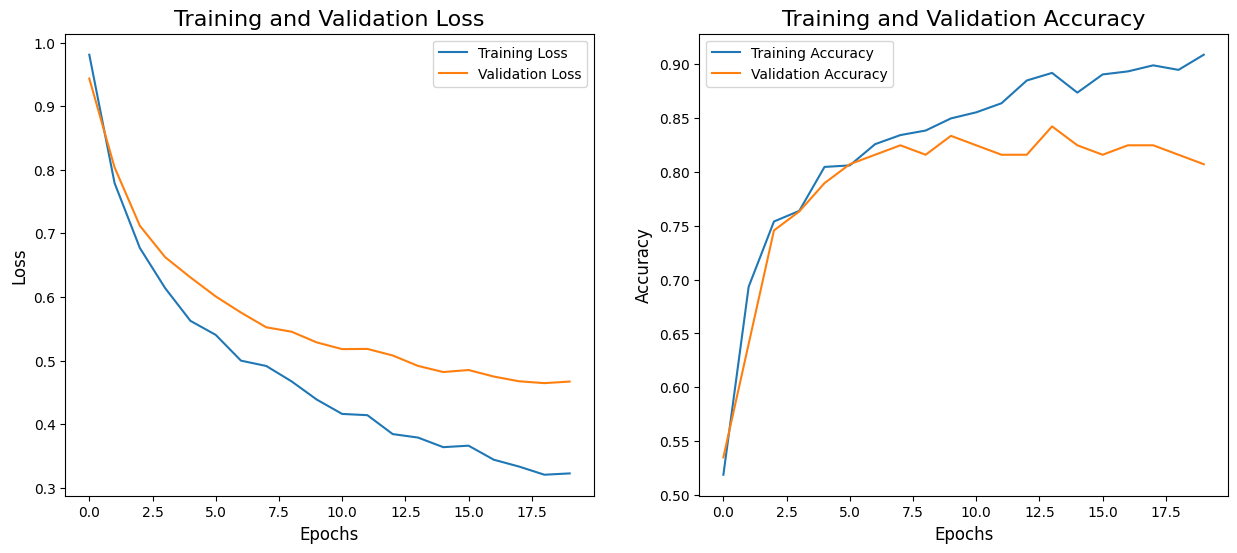

In [28]:
# ### 6.1. Loss and Accuracy Curves
def plot_loss_curves(history):
    """Plots training & validation accuracy and loss curves."""
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']
    epochs = range(len(history.history['loss']))

    plt.figure(figsize=(15, 6))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label='Training Loss')
    plt.plot(epochs, val_loss, label='Validation Loss')
    plt.title('Training and Validation Loss', fontsize=16)
    plt.xlabel('Epochs', fontsize=12)
    plt.ylabel('Loss', fontsize=12)
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label='Training Accuracy')
    plt.plot(epochs, val_accuracy, label='Validation Accuracy')
    plt.title('Training and Validation Accuracy', fontsize=16)
    plt.xlabel('Epochs', fontsize=12)
    plt.ylabel('Accuracy', fontsize=12)
    plt.legend()

    plt.show()

plot_loss_curves(history)

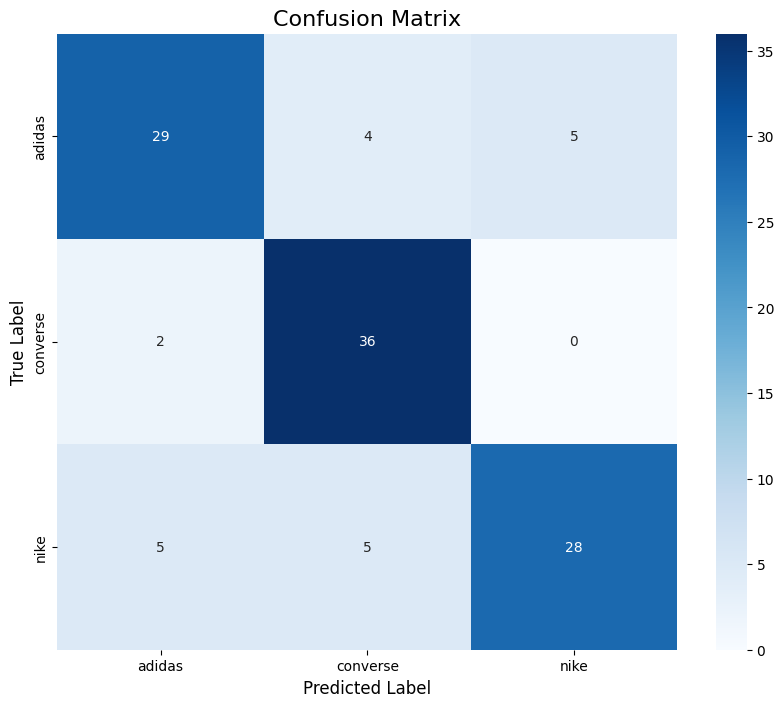


Classification Report:
              precision    recall  f1-score   support

      adidas       0.81      0.76      0.78        38
    converse       0.80      0.95      0.87        38
        nike       0.85      0.74      0.79        38

    accuracy                           0.82       114
   macro avg       0.82      0.82      0.81       114
weighted avg       0.82      0.82      0.81       114



In [29]:
# ### 6.2. Confusion Matrix & Classification Report
# 예측 및 실제 라벨 준비
pred_probs = model.predict(test_data, verbose=0)
y_preds = np.argmax(pred_probs, axis=1)

y_true = []
for images, labels in test_data.unbatch():
    y_true.append(np.argmax(labels.numpy()))

# 혼동 행렬(Confusion Matrix) 생성 및 시각화
cm = confusion_matrix(y_true, y_preds)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix', fontsize=16)
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.show()

# 분류 리포트(Classification Report) 출력
print("\nClassification Report:")
print(classification_report(y_true, y_preds, target_names=class_names))

Total misclassified images: 21



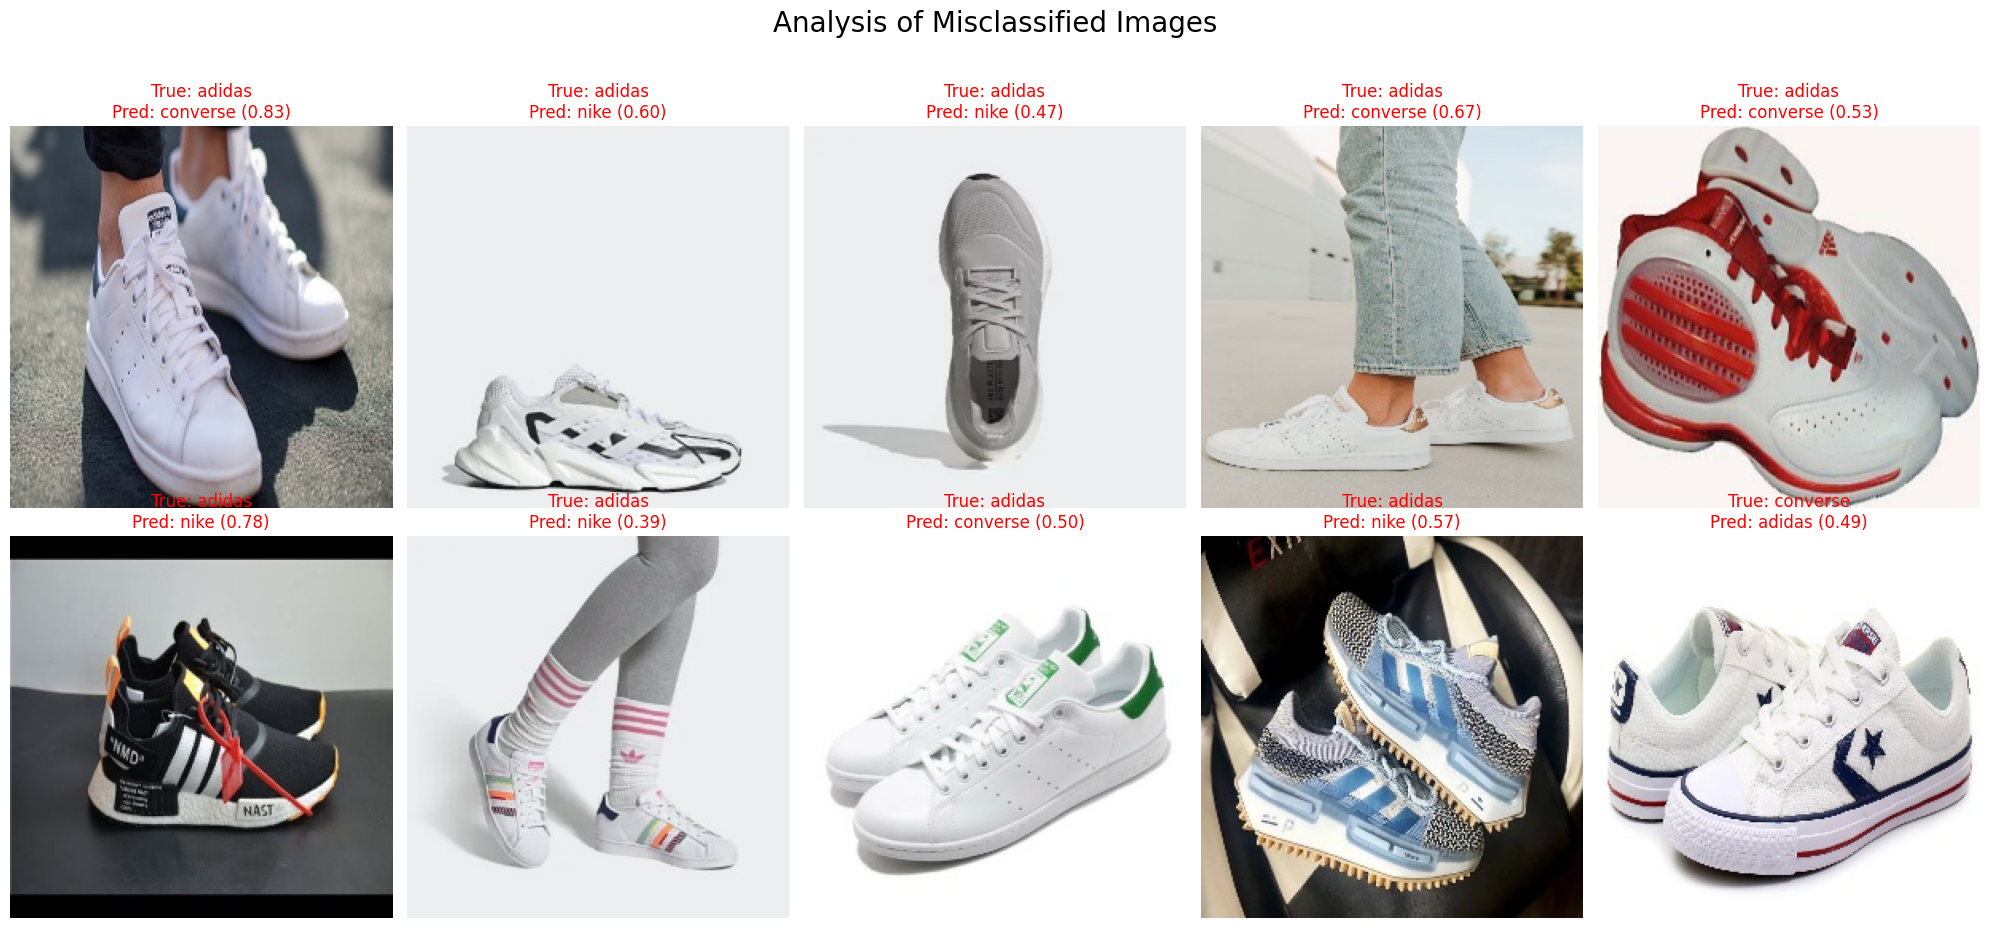

In [30]:
# ### 6.3. Analysis of Misclassified Images
# 오분류된 이미지의 인덱스 찾기
misclassified_indices = np.where(y_preds != y_true)[0]

if len(misclassified_indices) > 0:
    print(f"Total misclassified images: {len(misclassified_indices)}\n")

    # 모든 테스트 이미지 파일 경로 가져오기
    filepaths = test_data.file_paths

    # 일부 오분류 이미지 시각화 (최대 10개)
    plt.figure(figsize=(20, 10))
    for i, idx in enumerate(misclassified_indices[:10]):
        plt.subplot(2, 5, i + 1)
        img = mpimg.imread(filepaths[idx])
        plt.imshow(img)

        true_label = class_names[y_true[idx]]
        pred_label = class_names[y_preds[idx]]
        pred_prob = pred_probs[idx].max()

        plt.title(f"True: {true_label}\nPred: {pred_label} ({pred_prob:.2f})", fontsize=12, color='red')
        plt.axis('off')

    plt.suptitle('Analysis of Misclassified Images', fontsize=20)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()
else:
    print("Congratulations! No images were misclassified.")